<a href="https://colab.research.google.com/github/lf2foce/quant/blob/master/markowitz_chu%E1%BA%A9n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
# !pip install PyPortfolioOpt==1.2.5 
# !pip install cvxpy==1.1
# !pip install --upgrade firebase-admin
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10,6)})
%config InlineBackend.figure_format = 'retina'


In [159]:
start_date = '2012-01-04'
#vn30 = [ 'VNM', 'DXG']
vn30 = [ 'VIC',  'VPB', 'MWG']
#vn30 = [ 'VCB', 'CTG', 'BID', 'ACB', 'MBB', 'SHB'] # underperform
#vn30 = ["BID", "BVH", "CTD", "CTG", "EIB", "FPT", "GAS", "HDB", "HPG", "MBB", "MSN", "MWG", "NVL", "PLX", "PNJ", "POW", "REE", "ROS", "SAB", "SBT", "SSI", "STB", "TCB", "VCB", "VHM", "VIC", "VJC", "VNM", "VPB", "VRE"]
numstocks = len(vn30)
data_index = pd.read_csv('/content/drive/My Drive/data_analyst/data_index2012.csv')
data_index = data_index[['Ticker', 'Date', 'Close', 'AdjRatio']] #, 'Shares'
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index.Ticker.isin(vn30)) & (data_index['Date'] >= start_date) ] #& (data_index['Date'] < '2020-04-01')
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']
#data_index['Mcap'] = data_index['Close'] * data_index['Shares']
print(data_index.tail(5))

#pivot
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')
returns = data_index_pivot.pct_change()
avg_daily_return = returns.mean()

        Ticker       Date    Close  AdjRatio  Adj_Close
2428315    VIC 2020-08-21  86100.0       1.0    86100.0
2428352    VPB 2020-08-21  21900.0       1.0    21900.0
2429275    MWG 2020-08-24  84100.0       1.0    84100.0
2429937    VIC 2020-08-24  89000.0       1.0    89000.0
2429988    VPB 2020-08-24  23200.0       1.0    23200.0


In [160]:
%%time
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

EOM  = data_index_pivot.copy()
EOM_resample = EOM.resample('BQS').ffill()  #BQ business quarter end, BQS business quarter start, BMS month start
reb_date = list(EOM.resample('BQS').ffill().index)
#last reb là ngày cuối quý trước
if reb_date[-1] > pd.Timestamp.today():
  reb_date.pop()
weights_dfs = pd.DataFrame()
for i in range(5,len(reb_date)):
    print(reb_date[i])
    df = EOM.loc[:reb_date[i]].dropna(axis='columns', thresh=300).tail(100)
    print(df.head(1))
    print('last row cum return==============')
    print( ((df.pct_change() + 1).cumprod() -1).tail(1) )
    if ((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0] >0.01:
      print("--total return >0.02")
      try:
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)
          # Optimise for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S, weight_bounds=(0,0.8))   
          #ef.add_constraint(lambda x : x >= 0.01)
        raw_weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        print(cleaned_weights)
        ef.portfolio_performance(verbose=True)
        weights_df = pd.DataFrame({"weights": list(cleaned_weights.values()), "Ticker": list(cleaned_weights.keys())})
        weights_df =  weights_df[weights_df["weights"] != 0].reset_index(drop=True)
        weights_reb = weights_df
        weights_reb['Date'] = reb_date[i]
        weights_df = weights_df.set_index("Ticker", drop=True) # dùng để vẽ đồ thị
        weights_dfs = weights_dfs.append(weights_reb)     
      except:
        print("Không đủ dữ liệu")
        pass    

      # cách 2 shrinkage chua chay
      # expected_returns = expected_returns.mean_historical_return(df)
      # efficient_cov = risk_models.CovarianceShrinkage(df).ledoit_wolf()
      # ef = CLA(expected_returns, efficient_cov) #Constrained Line Algorithm object
      # minimum_variance = ef.min_volatility()
      # (ret, vol, raw_weights) = ef.efficient_frontier()
      
      

      
      
      #weights_df.plot(kind = 'bar')
      print("====================================================")

2013-04-01 00:00:00
Ticker               VIC
Date                    
2012-11-02  18473.817903
last row cum return==============
Ticker           VIC
Date                
2013-04-01  0.119839
--total return >0.02
Không đủ dữ liệu
2013-07-01 00:00:00
Ticker               VIC
Date                    
2013-01-30  21161.460444
last row cum return==============
Ticker          VIC
Date               
2013-07-01 -0.08209
2013-10-01 00:00:00
Ticker               VIC
Date                    
2013-05-14  20371.853711
last row cum return==============
Ticker          VIC
Date               
2013-10-01 -0.03876
2014-01-01 00:00:00
Ticker               VIC
Date                    
2013-08-13  20529.775057
last row cum return==============
Ticker           VIC
Date                
2013-12-31  0.076923
--total return >0.02
Không đủ dữ liệu
2014-04-01 00:00:00
Ticker               VIC
Date                    
2013-11-01  21161.460444
last row cum return==============
Ticker          VIC
Date         

In [161]:
data_index_opt = data_index.copy()
data_index_opt['Quarter'] = data_index_opt['Date'].dt.quarter
data_index_opt['Year'] = data_index_opt['Date'].dt.year
weights_dfs['Uni'] = 1
weights_dfs['Quarter'] = weights_dfs['Date'].dt.quarter
weights_dfs['Year'] = weights_dfs['Date'].dt.year

In [162]:
data_index_opt = pd.merge(data_index_opt, weights_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Quarter', 'Year']) #merrge w, y
data_index_opt['Uni']= data_index_opt['Uni'].fillna(0)
data_index_opt.to_csv("data_index_opt.csv")


In [163]:
#data_index_opt[data_index_opt["Date"] >= '2016-04-01'].tail(100)

In [164]:
a= data_index_opt.copy() #[data_index_opt['Ticker'].isin(['BID', 'VIC', 'VCB'])]
a=a[(a['Date'] >= '2015-01-01') ] # & (a['Date'] <='2020-01-02')  2013-01-01 start_date
a['return'] = a.groupby('Ticker')['Adj_Close'].apply(lambda x: (x/x.shift(1)) - 1).copy()
((a.groupby('Ticker')['return'].mean())  / a.groupby('Ticker')['return'].std() ) * np.sqrt(252)

portfolio = a.groupby("Date").apply(lambda row: (row['return'] * row['weights']).sum())

In [165]:
vn30_ew  = data_index_pivot.ffill().copy()
vn30_returns = vn30_ew.pct_change()
vn30_weghts_ew = np.repeat(1/numstocks, numstocks) #bị sai vì chưa đủ 30 mã
vn30_port_returns = vn30_returns.dot(vn30_weghts_ew)
vn30_port_returns_df = pd.DataFrame({"VN30_ew": vn30_port_returns})

In [166]:
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%Y-%m-%d')
vn30_index = index_price[index_price['Ticker'] == 'VN30'][['Date', 'Close']].set_index('Date').rename(columns={'Close': 'VN30'})

In [167]:
type(portfolio)
portfolio_df = pd.DataFrame({"optimized_VN30": portfolio})
#portfolio_df
combine_portfolio = pd.merge(portfolio_df, vn30_index.pct_change(), on='Date', how='left')
#merge tiep vn30_ew, kha nang bi sai, thieu ma
combine_portfolio = pd.merge(combine_portfolio, vn30_port_returns_df, on='Date', how='left')

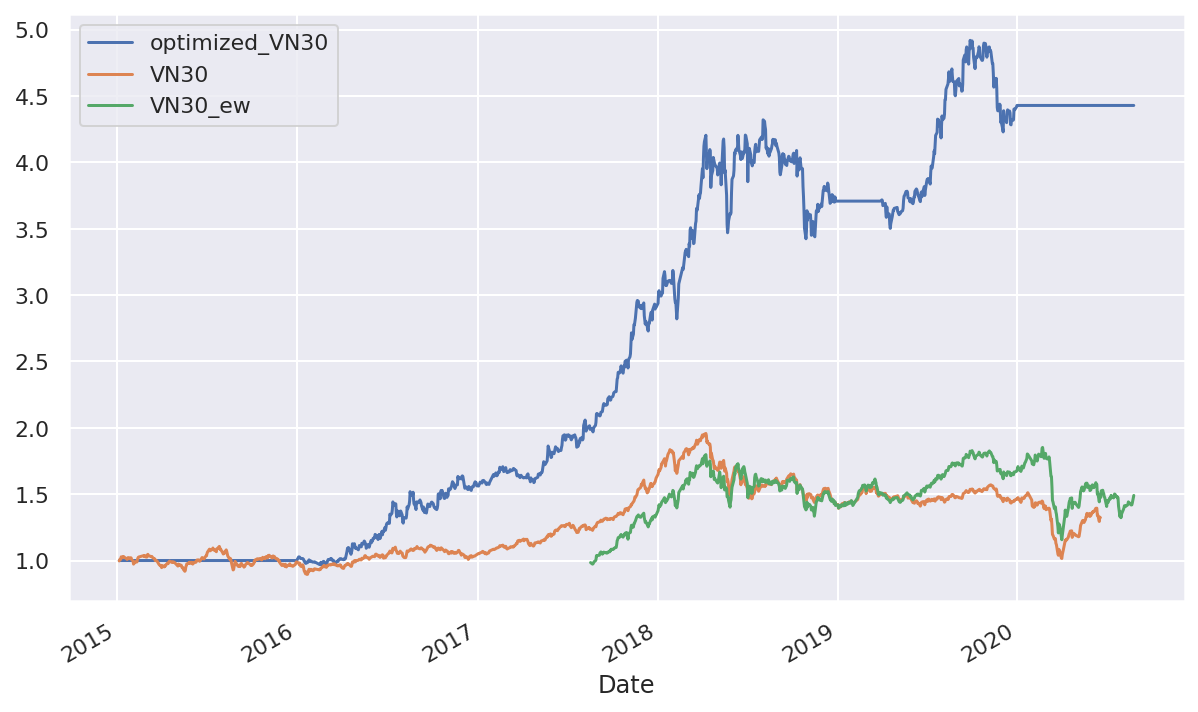

In [168]:
(combine_portfolio+1).cumprod().plot()

In [169]:
weights_dfs.head(30)
weights_dfs.to_csv("vn30_optimized_weights.csv")

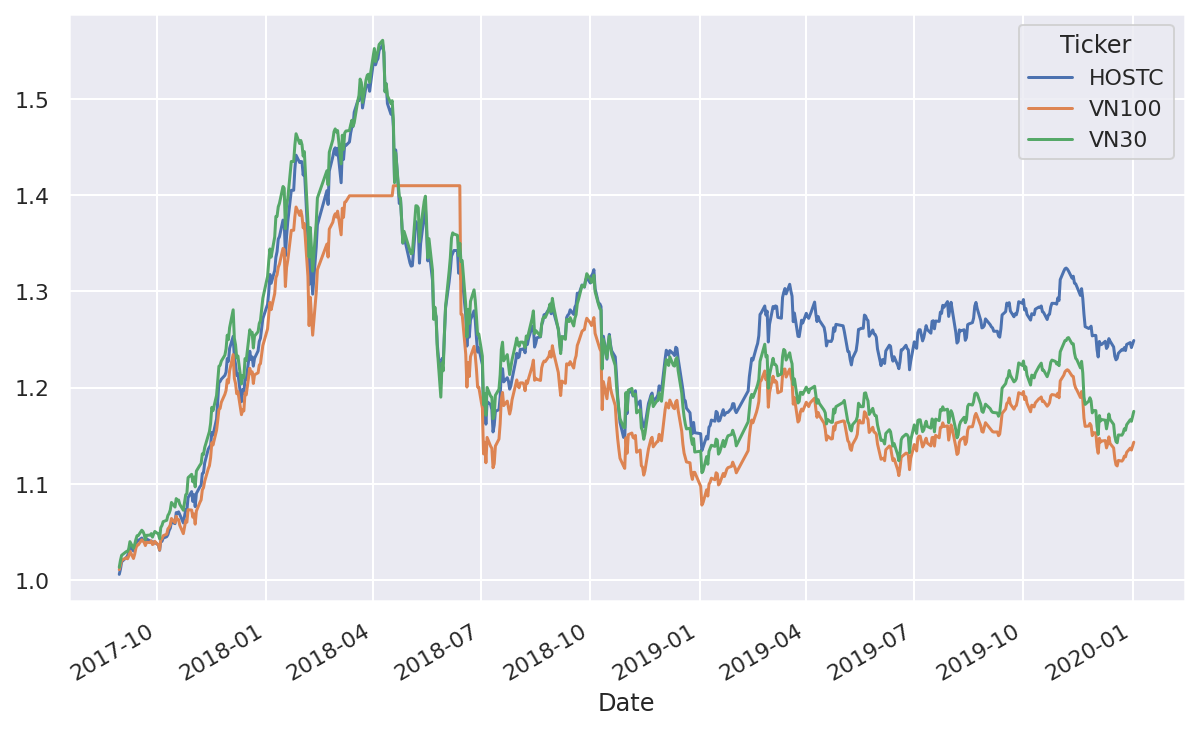

In [170]:
# so sánh index
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_pivot = index_price.pivot(index="Date", columns="Ticker", values="Close")
index_pivot = index_pivot['2017-08-29':'2020-01-02'][['HOSTC', 'VN100', 'VN30']]
index_pivot
return_index = index_pivot.pct_change()
#return_index['VN100'].dropna()
cum_ret = (return_index + 1).cumprod().dropna()
cum_ret.plot()
#return_index[['HOSTC', 'VN100', 'VN30', 'VNALL']].cumprod()

In [171]:
#end 

In [172]:
#firebase 
import datetime
import threading
from time import sleep

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Use a service account

#cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key.json")
cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key-flask-api.json")
firebase_admin.initialize_app(cred)
db = firestore.client()


ValueError: ignored

In [ ]:
# xử lý weights để push lên
weights_dfs
# weight_push = weights_dfs[(weights_dfs['Year'] == 2020) &  (weights_dfs['Quarter']  == 3)][['Ticker', 'weights']].set_index('Ticker')
# weight_dict = weight_push.to_dict()
# weight_dict['weights']

In [ ]:
doc_ref = db.collection('list1').document('weights')
doc_ref.set(
    weight_dict#['weights']
)

In [ ]:
doc_ref = db.collection('lists')
docs = doc_ref.stream()

for doc in docs:
    print(f'{doc.id} => {doc.to_dict()}')

In [ ]:

#test từ dưới
data_index[data_index['Ticker']=='HPG']

In [ ]:
#K
a= data_index[data_index['Ticker'].isin(['BID', 'VIC', 'VCB'])]
a=a[(a['Date'] >= '2015-01-01') & (a['Date'] <='2020-01-02')]
a['Close_adj'] = a['Close']/ a['AdjRatio']
a['ret'] = a.groupby('Ticker')['Close_adj'].apply(lambda x: (x/x.shift(1)) - 1).copy()
((a.groupby('Ticker')['ret'].mean())  / a.groupby('Ticker')['ret'].std() ) * np.sqrt(252)

In [ ]:
import pandas as pd
print(pd.__version__)
import cvxpy as cp
print(cp.__version__)
import numpy as np

In [ ]:
a =  {"tiker": ["A","B","A", "B"], "price": [12, 14, 15,18], "w1":[.5, .5, .6, .4], "group": ["G1", "G1", "G2", "G2"]}
b = pd.DataFrame(a)
b

In [ ]:
b.groupby("group").apply(lambda row: (row['w1'] * row['price']).sum())

In [ ]:
print( (((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1) <1 )

In [ ]:
((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0]


In [ ]:
list(index_price)

In [ ]:
import json
import pandas as pd
df = pd.DataFrame(
    [["a", "b"], ["c", "d"]],
    index=["row 1", "row 2"],
    columns=["col 1", "col 2"],
)
df

#dict(df.groupby("col 1")["col 2"].apply(list))

In [ ]:
#chuẩn to_dict
df = pd.read_csv('a.csv')
print(df)
df_groupby = df.groupby(['port_id', 'user_id', 'created_date', 'name'])['assets', 'weights'].agg(lambda x: list(x)).reset_index(level=['user_id', 'created_date', 'name'])
df_groupby.to_dict('index')

In [ ]:
# clean_weights
weights_df = pd.DataFrame({"weights": list(cleaned_weights.values()), "Ticker": list(cleaned_weights.keys())})

In [ ]:
{k: list(v) for k, v in df.groupby(['port_id', 'user_id'])['assets']}

In [ ]:
# đang làm
class City(object):
    def __init__(self, name, user_id, created_date, rebalance=False, rebnum=0,
                 weights={}):
        self.name = name
        self.user_id = user_id
        self.created_date = created_date
        self.rebalance = rebalance
        self.rebnum = rebnum
        self.weights = weights

    @staticmethod
    def from_dict(source):
        # [START_EXCLUDE]
        city = City(source['name'], source['user_id'], source['created_date'])

        if 'rebalance' in source:
            city.rebalance = source['rebalance']

        if 'rebnum' in source:
            city.rebnum = source['rebnum']

        if 'weights' in source:
            city.weights = source['weights']

        return city
        # [END_EXCLUDE]

    def to_dict(self):
        # [START_EXCLUDE]
        dest = {
            'name': self.name,
            'user_id': self.user_id,
            'created_date': self.created_date
        }

        if self.rebalance:
            dest['rebalance'] = self.rebalance

        if self.rebnum:
            dest['rebnum'] = self.rebnum

        if self.weights:
            dest['weights'] = self.weights

        return dest
        # [END_EXCLUDE]

    def __repr__(self):
        return(
            f'City(\
                name={self.name}, \
                created_date={self.created_date}, \
                rebnum={self.rebnum}, \
                rebalance={self.rebalance}, \
                weights={self.weights}\
            )'
        )
# [END custom_class_def]


def add_example_data():
    #db = firestore.Client()
    # [START add_example_data]
    cities_ref = db.collection(u'lists')
    cities_ref.document('list1').set(
        City('LTI', 1, u'2020-09-07', True, 3, {"VCB": 0.3}).to_dict())
    cities_ref.document('list2').set(
        City('Blah', 2, '2020-09-07', False, 0,
             {}).to_dict())
    cities_ref.document('list3').set(
        City('Blah', 1, '2020-09-07', True, 4,
             {}).to_dict())
    cities_ref.document('1').set(
        City('Blah', 1, '2020-09-07', True, 4,
             {}).to_dict())    
    # [END add_example_data]
add_example_data() 